# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察計數編碼與特徵雜湊的效果

# [作業重點]
- 仿造範例, 完成自己挑選特徵的群聚編碼 (In[2], Out[2])
- 觀察群聚編碼, 搭配邏輯斯回歸, 看看有什麼影響 (In[5], Out[5], In[6], Out[6]) 

# 作業1
* 試著使用鐵達尼號的例子，創立兩種以上的群聚編碼特徵( mean、median、mode、max、min、count 均可 )

In [77]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [78]:
# 取一個類別型欄位, 與一個數值型欄位, 做群聚編碼
"""
Your Code Here
"""
df['Ticket'] = df['Ticket'].fillna('None')
df['Age'] = df['Age'].fillna(df['Age'].mean())

mean_df = df.groupby(['Ticket'])['Age'].mean().reset_index()
mode_df = df.groupby(['Ticket'])['Age'].apply(lambda x: x.mode()[0]).reset_index()
median_df = df.groupby(['Ticket'])['Age'].median().reset_index()
max_df = df.groupby(['Ticket'])['Age'].max().reset_index()
min_df = df.groupby(['Ticket'])['Age'].min().reset_index()

In [79]:
temp = pd.merge(mean_df, mode_df, how='left', on=['Ticket'])
temp = pd.merge(temp, median_df, how='left', on=['Ticket'])
temp = pd.merge(temp, max_df, how='left', on=['Ticket'])
temp = pd.merge(temp, min_df, how='left', on=['Ticket'])
temp.columns = ['Ticket', 'Age_Mean', 'Age_Mode', 'Age_median', 'Age-Max', 'Age-Min']
temp

,Ticket,Age_Mean,Age_Mode,Age_median,Age-Max,Age-Min
0,110152,26.333333,16.000000,30.000000,33.000000,16.000000
1,110413,36.333333,18.000000,39.000000,52.000000,18.000000
2,110465,38.349559,29.699118,38.349559,47.000000,29.699118
3,110564,28.000000,28.000000,28.000000,28.000000,28.000000
4,110813,60.000000,60.000000,60.000000,60.000000,60.000000
...,...,...,...,...,...,...
676,W./C. 6608,23.500000,9.000000,18.500000,48.000000,9.000000
677,W./C. 6609,29.699118,29.699118,29.699118,29.699118,29.699118
678,W.E.P. 5734,46.000000,46.000000,46.000000,46.000000,46.000000
679,W/C 14208,30.000000,30.000000,30.000000,30.000000,30.000000


In [80]:
df = pd.merge(df, temp, how='left', on=['Ticket'])
df = df.drop(['Ticket'], axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_Mean,Age_Mode,Age_median,Age-Max,Age-Min
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,22.0,22.0,22.0,22.0,22.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,38.0,38.0,38.0,38.0,38.0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,26.0,26.0,26.0,26.0,26.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,36.0,35.0,36.0,37.0,35.0
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,35.0,35.0,35.0,35.0,35.0


In [81]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df

10 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_Mean', 'Age_Mode', 'Age_median', 'Age-Max', 'Age-Min']



,Pclass,Age,SibSp,Parch,Fare,Age_Mean,Age_Mode,Age_median,Age-Max,Age-Min
0,3,22.000000,1,0,7.2500,22.000000,22.000000,22.000000,22.000000,22.000000
1,1,38.000000,1,0,71.2833,38.000000,38.000000,38.000000,38.000000,38.000000
2,3,26.000000,0,0,7.9250,26.000000,26.000000,26.000000,26.000000,26.000000
3,1,35.000000,1,0,53.1000,36.000000,35.000000,36.000000,37.000000,35.000000
4,3,35.000000,0,0,8.0500,35.000000,35.000000,35.000000,35.000000,35.000000
...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,27.000000,27.000000,27.000000,27.000000,27.000000
887,1,19.000000,0,0,30.0000,19.000000,19.000000,19.000000,19.000000,19.000000
888,3,29.699118,1,2,23.4500,29.699118,29.699118,29.699118,29.699118,29.699118
889,1,26.000000,0,0,30.0000,26.000000,26.000000,26.000000,26.000000,26.000000


# 作業2
* 將上述的新特徵，合併原有的欄位做生存率預估，結果是否有改善?

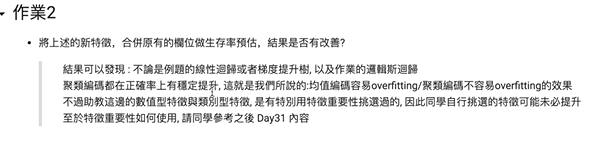

In [83]:
# 原始特徵 + 邏輯斯迴歸
"""
Your Code Here
"""
df_minus = df.drop(['Age_Mean', 'Age_Mode', 'Age_median', 'Age-Max', 'Age-Min'], axis=1)
train_X = MMEncoder.fit_transform(df_minus)
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7004142866110099

In [85]:
# 新特徵 + 邏輯斯迴歸
"""
Your Code Here
"""
train_X = MMEncoder.fit_transform(df)
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.702661477622246